In [1]:
import numpy as np
bases = ['A', 'C', 'G', 'T']
import matplotlib.pyplot as plt
from sklearn import metrics
%matplotlib inline

# Load data

In [2]:
from genome import Genome
genome = Genome('/Users/jpaggi/Downloads/MPRA/snps/hg19.fa')

In [3]:
phastcons = {}
with open('../anno/hg19.100way.phastCons.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phastcons: phastcons[chrom] = {}
        phastcons[chrom][int(pos)] = float(score)
phylop = {}
with open('../anno/hg19.100way.phyloP100way.bp.bed') as fp:
    for line in fp:
        chrom, pos, _, score = line.strip().split()
        if chrom not in phylop: phylop[chrom] = {}
        phylop[chrom][int(pos)] = float(score)

In [44]:
# file result of bedtools intersect -loj
introns = {}
with open('../preprocessing/introns_to_taggart.tsv') as fp:
    for line in fp:
        chrom, start, end, _, pos, strand, _, bp = line.split('\t')[:8]
        bp, start, end = int(bp), int(start), int(end)
        
        three = end if strand == '+' else start  
        key = (chrom, three, strand)
        
        if not 5 < abs(bp - three) < 60:
            bp = -1
        
        if key not in introns: introns[key] = []
        if (bp not in introns[key]
            and bp != -1): introns[key] += [bp]

In [47]:
# Used to compare to branchpointer
c = 0
with open('../anno/test_taggart.tsv', 'w') as fp:
    ID = 0
    fp.write('\t'.join(['id', 'chromsome', 'start', 'end', 'strand']) + '\n')
    for (chrom, three, strand), bp in introns.items():
        if not bp or chrom != 'chr1':
            continue
        if strand == '+':
            begin, end = str(three - 70), str(three)
        else:
            
            begin, end = str(three+1), str(three + 70+1)
        c += 1
        fp.write('\t'.join(["chr1_{}_{}".format(three, strand),
                            'chr1', begin, end, strand]) + '\n')
print c

2342


In [5]:
known   = {key: value for key, value in introns.items() if value}
missing = {key: value for key, value in introns.items() if not value}
print len(known)
print len(missing)

22020
184272


In [6]:
L = 70

def onehot(seq):
    X = np.zeros((len(seq), len(bases)))
    for i, char in enumerate(seq):
        X[i, bases.index(char)] = 1
    return X

def encode(introns, phastcons, phylop):
    X, y, chroms, coords, strands = [], [], [], [], []
    for intron, bps in introns.items():
        chrom, three, strand = intron
        if strand == '+':
            begin, stop = three - L, three
        else:
            begin, stop = three, three + L

        # Get features
        seq = genome.get_seq(chrom, begin, stop, strand)
        if 'N' in seq: seq = seq.replace('N', 'A')

        c1 = np.array([phastcons[chrom][pos] if pos in phastcons[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        c2 = np.array([phylop[chrom][pos] if pos in phylop[chrom] else 0
                      for pos in range(begin, stop)]).reshape(-1, 1)
        
        if strand == '-':
            c1 = c1[::-1]
            c2 = c2[::-1]
        X += [np.hstack([onehot(seq), c1, c2]).reshape(1, L, 6)]

        # Make target
        _y = np.zeros((stop - begin,))
        for bp in bps:
            if strand == '+':
                bp = L + bp - three - 1
            else:
                bp = L - bp + three - 1
            _y[bp] = 1
            
        y += [_y]
        
        chroms += [chrom]
        coords += [three]
        strands += [strand]
    return (np.vstack(X), np.vstack(y),
            np.array(chroms), np.array(coords), np.array(strands))

X, y, chroms, coords, strands = encode(known, phastcons, phylop)

coords = coords[chroms == 'chr1']
strands = strands[chroms == 'chr1']
print np.sum(y == 1)
print np.sum(y == -1)
print X.shape

25324
0
(22020, 70, 6)


In [7]:
test = np.array(map(lambda x: x == 'chr1', chroms))
valid = np.array(map(lambda x: x in ('chr2', 'chr3', 'chr4', 'chr5'),
                     chroms))
train = np.array([not (t or v) for t, v in zip(test, valid)])
print sum(test),  sum(valid), sum(train)

X_train, X_valid, X_test = X[train], X[valid], X[test]
y_train, y_valid, y_test = y[train], y[valid], y[test]
print X_train.shape, X_valid.shape, X_test.shape
print y_train.shape, y_valid.shape, y_test.shape

2342 4568 15110
(15110, 70, 6) (4568, 70, 6) (2342, 70, 6)
(15110, 70) (4568, 70) (2342, 70)


# Baseline models

In [8]:
def matching(preds, true):
    total, match = 0, 0
    for p, t in zip(preds, true):
        if np.argmax(p) in np.nonzero(t)[0]:
            match += 1
        total += 1
    return match, total

# Conservation Meta

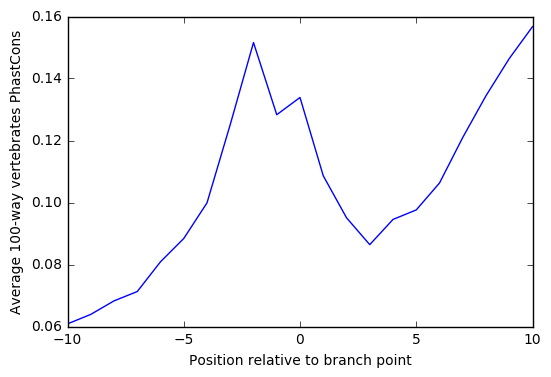

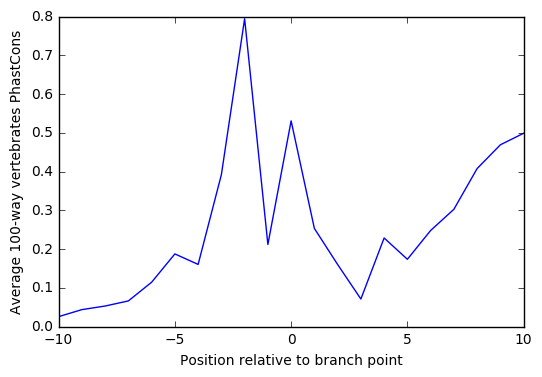

In [48]:
K = 10
counts = np.zeros((2*K+1,))
total = 0
for target, seq in zip(y_train, X_train):
    for bp in np.array(range(L))[target == 1]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, 4]
        total += 1
plt.plot(range(-K, K+1), counts / total)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average 100-way vertebrates PhastCons')
plt.show()

K = 10
counts = np.zeros((2*K+1,))
total = 0
for target, seq in zip(y_train, X_train):
    for bp in np.array(range(L))[target == 1]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, 5]
        total += 1
plt.plot(range(-K, K+1), counts / total)
plt.xlabel('Position relative to branch point')
plt.ylabel('Average 100-way vertebrates PhastCons')
plt.show()

# Dist Model

[    0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
    17.    14.    24.    20.    26.    21.    31.    25.    34.    41.
    41.    43.    46.    51.    60.    72.    76.    89.   103.   117.
   136.   170.   173.   200.   232.   324.   363.   406.   494.   621.
   684.   826.   876.  1007.  1108.  1253.  1228.  1251.  1181.  1014.
   851.   639.   457.   288.   166.   104.    91.    70.    47.    34.
    37.    28.    30.    27.     0.     0.     0.     0.     0.     0.]


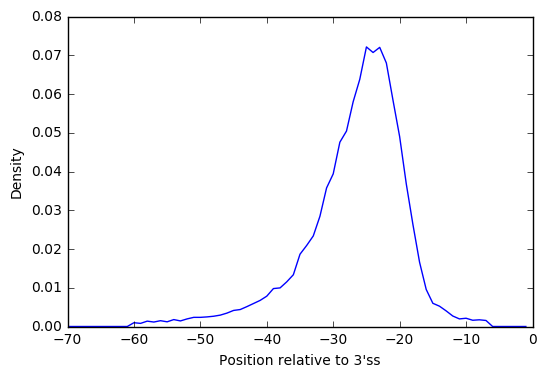

In [10]:
counts = np.zeros((L,))
total = 0
for target, seq in zip(y_train, X_train):
    for bp in np.array(range(L))[target == 1]:
        counts[bp] += 1
        total += 1
print counts
dists = counts / float(total)
plt.plot(range(-70, 0), dists)
plt.ylabel('Density')
plt.xlabel("Position relative to 3'ss")
plt.show()

In [11]:
def dist_pred(X, dists):
    return np.vstack([dists.T] * X.shape[0])

print matching(dist_pred(X_test, dists), y_test)
print matching(dist_pred(X_train, dists), y_train)

(178, 2342)
(1253, 15110)


# PWM model

In [12]:
K = 3
counts = np.zeros((2*K+1, 4))
total = 0
for target, seq in zip(y_train, X_train):
    for bp in np.array(range(L))[target == 1]:
        if 0 > bp-K or bp+K+1 > seq.shape[0]: continue
        counts = counts + seq[bp-K: bp+K+1, :4]
        total += 1
pwm = counts / total

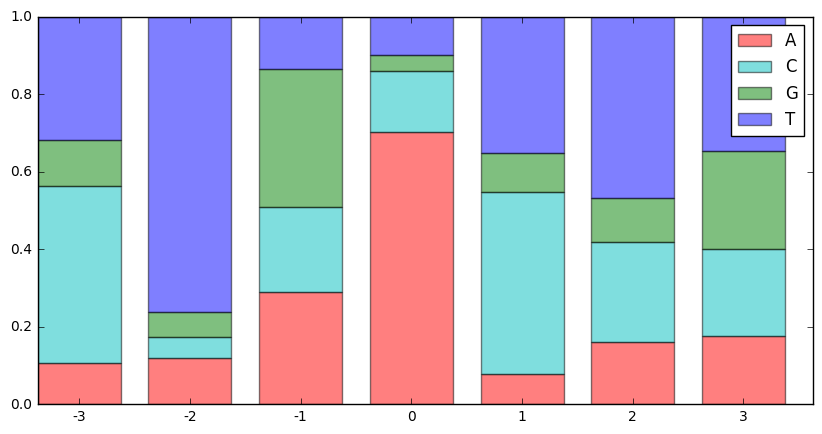

In [13]:
def pwm_logo(pwm, title = ''):
    f, ax1 = plt.subplots(1, figsize=(10,5))
    bar_width = 0.75
    bar_l = [i+1 for i in range(pwm.shape[0])]
    tick_pos = [i+(bar_width/2) for i in bar_l]

    for i, (char, color) in enumerate(zip(['A', 'C', 'G', 'T'],
                                 ['r', 'c','g', 'b'])):
        # Create a bar plot, in position bar_1
        ax1.bar(bar_l,
                pwm[:, i],
                width=bar_width,
                label=char,
                bottom=np.sum(pwm[:, :i], axis = 1),
                alpha=0.5,
                color = color)
    plt.xticks(tick_pos, range(-K, K+1))
    plt.legend()
    plt.title(title)
    plt.ylim(0, 1)
    plt.show()
pwm_logo(pwm)

In [14]:
def pwm_pred(X, pwm):
    scores = []
    for seq in X:
        s = [0] * K
        for i in range(seq.shape[0] - K*2):
            s += [np.sum(seq[i:i+2*K+1, :4] * pwm)]
        s += [0] * K
        scores += [np.array(s)]
    return np.vstack(scores)

print matching(pwm_pred(X_test, pwm), y_test)
print matching(pwm_pred(X_train, pwm), y_train)

(794, 2342)
(5178, 15110)


# Load model

In [16]:
from keras.models import load_model
model = load_model('../models/2layer.h5')

Using Theano backend.


In [17]:
train_preds = model.predict(X_train[:, :, :4]).reshape(-1, 70)
valid_preds = model.predict(X_valid[:, :, :4]).reshape(-1, 70)
test_preds = model.predict(X_test[:, :, :4]).reshape(-1, 70)

# Model Performance

In [39]:
def shifted_matching(preds, true, title):
    E, B = 4, 4
    total, match, low_match, low_shifted, shifted = 0, 0, 0, 0, 0
    for p, t in zip(preds, true):
        if not np.sum(t==1): continue
        bp = np.argmax(p)
        if bp in np.array(range(L))[t == 1]:
            match += 1
        elif any(i in np.array(range(L))[t == 1]
                 for i in range(bp-E, bp+B+1)):
            shifted += 1
        ### above is high conf, below is low conf
        if bp in np.array(range(L))[t != 0]:
            low_match += 1
        elif any(i in np.array(range(L))[t != 0]
                 for i in range(bp-E, bp+B+1)):
            low_shifted += 1
            
        total += 1
    print total, match
    heights = [match / float(total),  low_match / float(total),
               (match+shifted) / float(total),
               (low_match+low_shifted) / float(total),
              ]
    index = [0, .15, .3, .45]
    plt.bar(index, heights, .1, align = 'center', alpha = 0.5)
    plt.ylim(.5, 1)
    plt.xticks(index, ['High Conf',
                       'Low Conf',
                       '<4 High',
                       '<4 Low'])
    plt.yticks(heights, map(lambda x: "{}%".format(int(x * 100)), heights))
    plt.ylabel("Highest scoring branchpoint for 3'ss")
    plt.title(title)
    plt.show()
    return total, heights

# Compare to branchpointer

Do separately becuase I can't get branchpointer to predict
scores for a subset of of our test set.

This evaluation matches bptrs own performance evaluation to the letter.

In [49]:
# Load in scores from branchpointer
pos  = []
for line in open('../anno/branchpointer.taggart.pos.tsv'):
    pos += map(int, line.strip().split())
scores = []
for line in open('../anno/branchpointer.taggart.score.tsv'):
    scores += map(float, line.strip().split())
bptr = {p:score for p, score in zip(pos, scores)}
print len(bptr)
bptr_preds = np.zeros((len(coords), 27))
for i, (three, strand) in enumerate(zip(coords, strands)):
    region = (range(three-44, three - 17)
              if strand == '+' else
              range(three + 45, three + 18, -1))
    #if strand == '+':continue
    for j, pos in enumerate(region):
        bptr_preds[i, j] = bptr[pos] if pos in bptr else 0

61242


In [50]:
idx = np.max(bptr_preds, axis = 1) > 0

lstm   = test_preds[idx]
y_filt = y_test[idx]
bptr   = np.hstack([np.zeros((sum(idx), 25)),
                    bptr_preds[idx],
                    np.zeros((sum(idx), 18))])

2081 1270


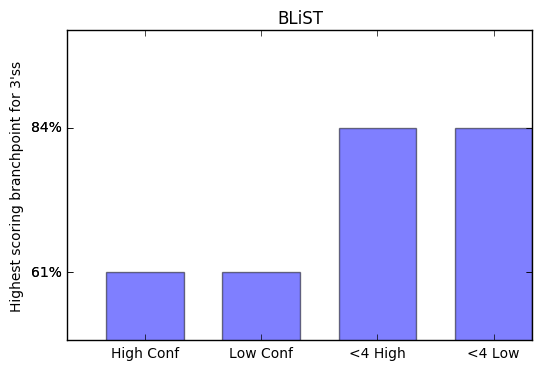

2081 1182


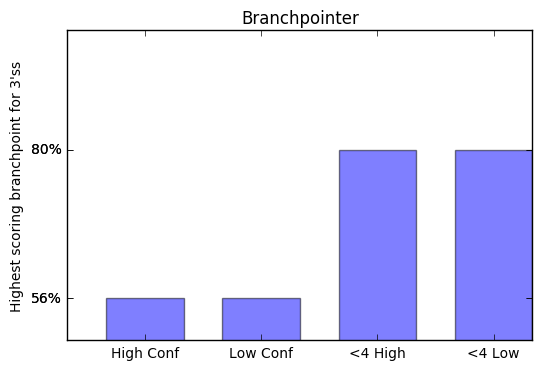

0.0831088649513
0.0831088649513
0.177701407611
0.177701407611


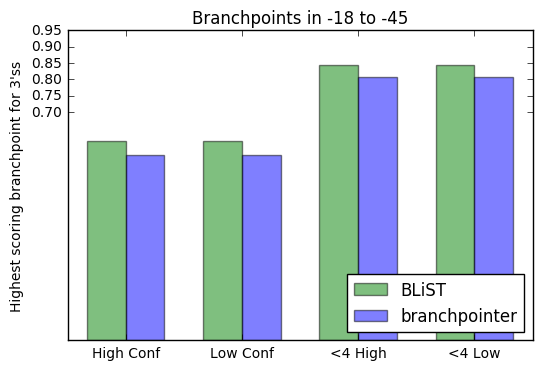

2290 1315


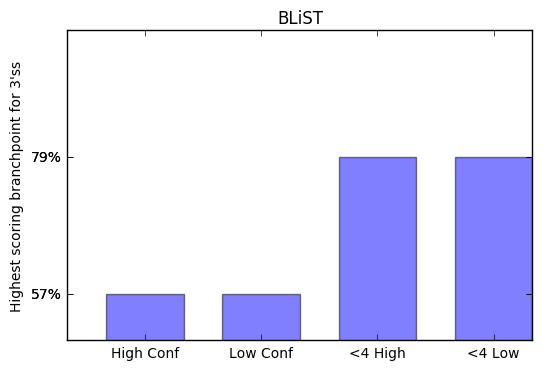

2290 1182


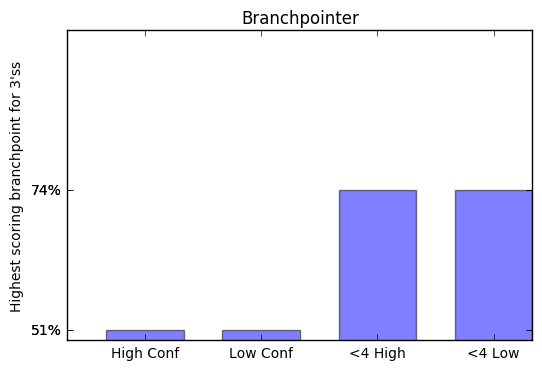

0.0226562873274
0.0226562873274
0.0731965862984
0.0731965862984


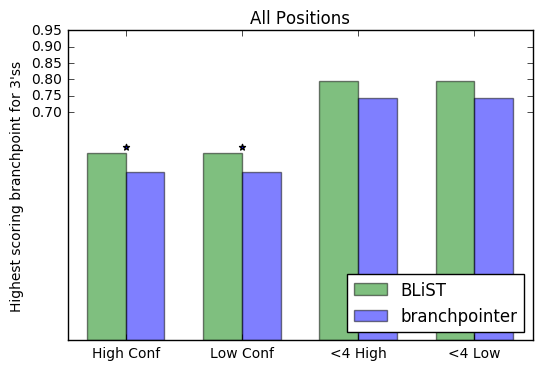

In [51]:
from scipy.stats import fisher_exact
labels = ['High Conf','Low Conf','<4 High','<4 Low']

L = 27
lstm_t, lstm_h = shifted_matching(lstm[:, -45:-18], y_filt[:, -45:-18], 'BLiST')
bptr_t, bptr_h = shifted_matching(bptr[:, -45:-18], y_filt[:, -45:-18], 'Branchpointer')
assert lstm_t == bptr_t

sig = []
for i, label in enumerate(labels):
    odds, pvalue =  fisher_exact([[lstm_h[i]*lstm_t, lstm_t],
                                  [bptr_h[i]*bptr_t, bptr_t]], 'greater')
    print pvalue
    if pvalue < .05:
        sig += [i*.3]
plt.scatter(sig, map(lambda x: .02+max(lstm_h[int(x/.3)], bptr_h[int(x/.3)]), sig), marker = '*')

plt.bar(np.linspace(0, .9, 4)-.05, lstm_h, .1, align = 'center', alpha = 0.5,  color = 'green', label = 'BLiST')
plt.bar(np.linspace(0, .9, 4)+.05, bptr_h, .1, align = 'center', alpha = 0.5, label = 'branchpointer')
plt.xlim(-.15, 1.05)
plt.xticks(np.linspace(0, .9, 4), labels)
plt.yticks(np.linspace(.7, .95, 6))
plt.ylabel("Highest scoring branchpoint for 3'ss")
plt.title('Branchpoints in -18 to -45')
plt.legend(loc = 4)
plt.ylim(0)
plt.show()

L = 70
lstm_i, lstm_h = shifted_matching(lstm, y_filt, 'BLiST')
bptr_i, bptr_h = shifted_matching(bptr, y_filt, 'Branchpointer')

sig = []
for i, label in enumerate(labels):
    odds, pvalue =  fisher_exact([[lstm_h[i]*lstm_t, lstm_t],
                                  [bptr_h[i]*bptr_t, bptr_t]], 'greater')
    print pvalue
    if pvalue < .05:
        sig += [i*.3]
plt.scatter(sig, map(lambda x: .02+max(lstm_h[int(x/.3)], bptr_h[int(x/.3)]), sig), marker = '*')
plt.bar(np.linspace(0, .9, 4)-.05, lstm_h, .1, align = 'center', alpha = 0.5,  color = 'green', label = 'BLiST')
plt.bar(np.linspace(0, .9, 4)+.05, bptr_h, .1, align = 'center', alpha = 0.5, label = 'branchpointer')
plt.xticks(np.linspace(0, .9, 4), labels)
plt.xlim(-.15, 1.05)
plt.ylim(0)
plt.yticks(np.linspace(.7, .95, 6))
plt.ylabel("Highest scoring branchpoint for 3'ss")
plt.title('All Positions')
plt.legend(loc = 4)
plt.show()

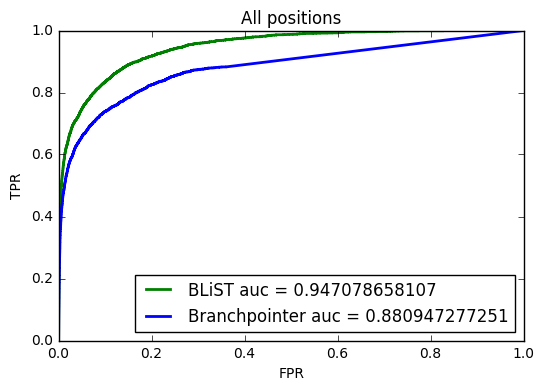

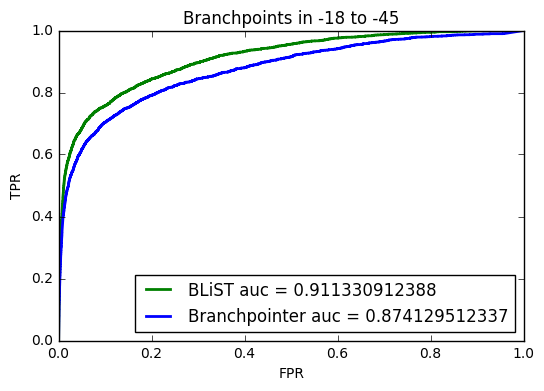

In [52]:
def bptr_roc(y, bptr, lstm, title):
    bptr = bptr[np.max(y, axis = 1)>0].flatten()
    lstm = lstm[np.max(y, axis = 1)>0].flatten()
    y = y[np.max(y, axis = 1)>0].flatten()
    
    fpr, tpr, thresholds = metrics.roc_curve(y[y != -1],
                                             lstm[y != -1],
                                             pos_label=1)
    auc = metrics.roc_auc_score(y[y != -1],
                                lstm[y != -1])
    plt.plot(fpr, tpr, label = "BLiST auc = {}".format(auc), lw = 2, c = 'g')

    fpr, tpr, thresholds = metrics.roc_curve(y[y != -1],
                                             bptr[y != -1],
                                             pos_label=1)
    auc = metrics.roc_auc_score(y[y != -1],
                                bptr[y != -1])
    plt.plot(fpr, tpr, label = "Branchpointer auc = {}".format(auc), lw = 2, c = 'b')

    plt.legend(loc = 4)
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.title(title)
    plt.show()

bptr_roc(y_filt, bptr, lstm, 'All positions')
bptr_roc(y_filt[:, -45:-18], bptr[:, -45:-18], lstm[:, -45:-18], 'Branchpoints in -18 to -45')

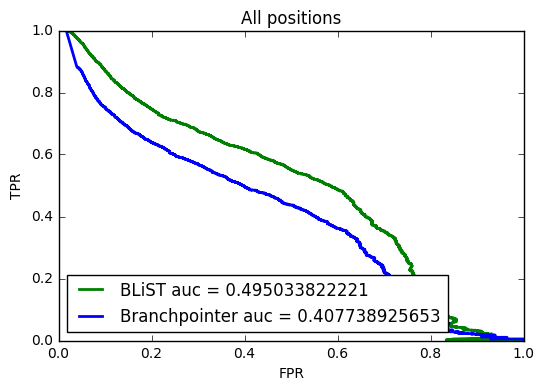

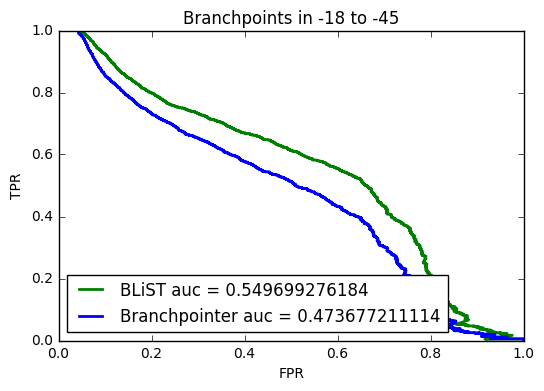

In [53]:
def bptr_prc(y, bptr, lstm, title):
    bptr = bptr[np.max(y, axis = 1)>0].flatten()
    lstm = lstm[np.max(y, axis = 1)>0].flatten()
    y = y[np.max(y, axis = 1)>0].flatten()
    
    fpr, tpr, _ = metrics.precision_recall_curve(y[y != -1],
                                                 lstm[y != -1],
                                                 pos_label=1)
    auc = metrics.average_precision_score(y[y != -1],
                                          lstm[y != -1])
    plt.plot(fpr, tpr, label = "BLiST auc = {}".format(auc), lw = 2, c = 'g')

    fpr, tpr, _ = metrics.precision_recall_curve(y[y != -1],
                                                 bptr[y != -1],
                                                 pos_label=1)
    auc = metrics.average_precision_score(y[y != -1],
                                          bptr[y != -1])
    plt.plot(fpr, tpr, label = "Branchpointer auc = {}".format(auc), lw = 2, c = 'b')
    plt.legend(loc = 3)
    plt.ylabel("TPR")
    plt.xlabel("FPR")
    plt.title(title)
    plt.show()

bptr_prc(y_filt, bptr, lstm, 'All positions')
bptr_prc(y_filt[:, -45:-18], bptr[:, -45:-18], lstm[:, -45:-18], 'Branchpoints in -18 to -45')

## auROC on train, valid, test

I think that this metric isn't very helpful in this setting.

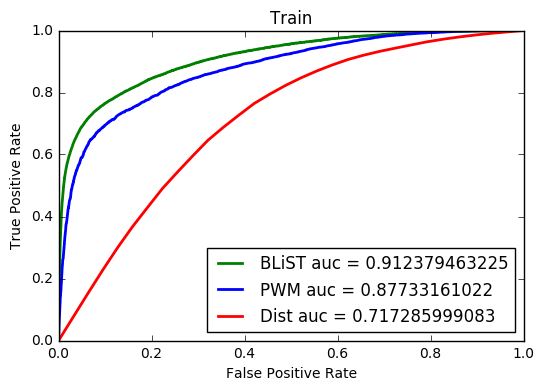

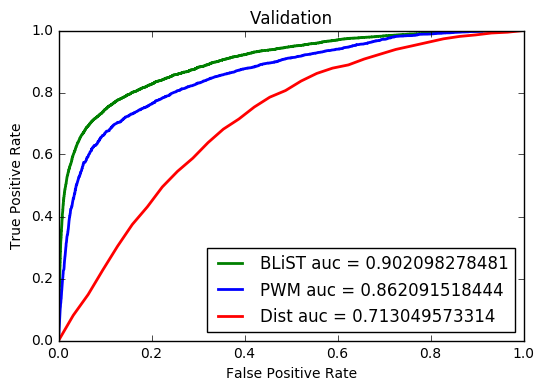

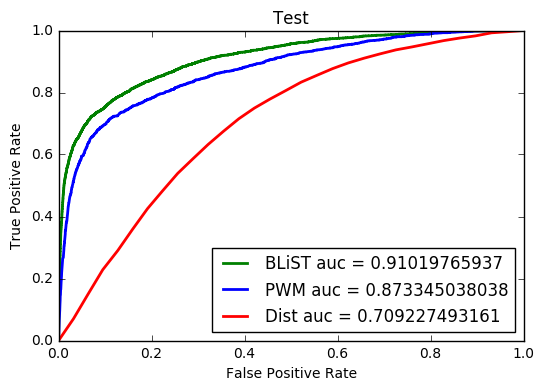

In [19]:
K=3

def roc(X, y, p, begin, end, title):
    # Enter begin, end as distance from 3'SS
    # Convert to proper index...
    begin, end = 70 - end, 70 - begin
    
    # Filter for example where BP is in range
    idx = np.sum(y[:, begin:end], axis = 1).flatten() > 0
    _y, _p, _X = y[idx], p[idx], X[idx]
    truth = _y[:, begin:end].flatten()
    
    mask = truth != -1
    
    scores = _p[:, begin:end].flatten()[mask]
    fpr, tpr, thresholds = metrics.roc_curve(truth[mask],
                                             scores, pos_label=1)
    auc = metrics.roc_auc_score(truth[mask], scores)
    plt.plot(fpr, tpr, label = "BLiST auc = {}".format(auc), lw = 2, c = 'g')
    
    scores = pwm_pred(_X, pwm)[:, begin:end].flatten()[mask]
    fpr, tpr, thresholds = metrics.roc_curve(truth[mask],
                                             scores, pos_label=1)
    auc = metrics.roc_auc_score(truth[mask], scores)
    plt.plot(fpr, tpr, label = "PWM auc = {}".format(auc), lw = 2, c = 'b')
    
    scores = dist_pred(_X, dists)[:, begin:end].flatten()[mask]
    fpr, tpr, thresholds = metrics.roc_curve(truth[mask],
                                             scores, pos_label=1)
    auc = metrics.roc_auc_score(truth[mask], scores)
    plt.plot(fpr, tpr, label = "Dist auc = {}".format(auc), lw = 2, c = 'r')
    
    plt.legend(loc = 'best')
    plt.title(title)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
roc(X_train[:, :, :4], y_train, train_preds, 15, 45, 'Train')
roc(X_valid[:, :, :4], y_valid, valid_preds, 15, 45, 'Validation')
roc(X_test[:, :, :4],  y_test,  test_preds,  15, 45, 'Test')

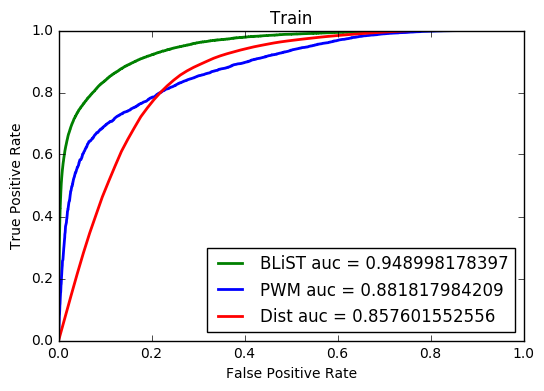

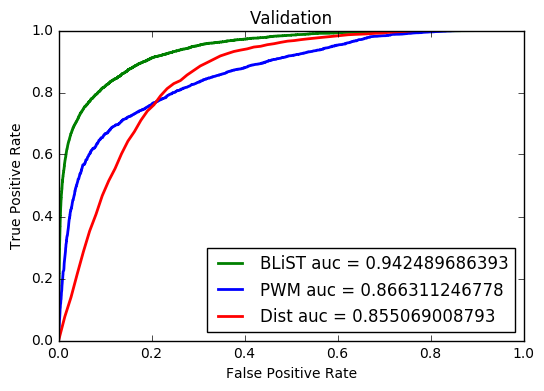

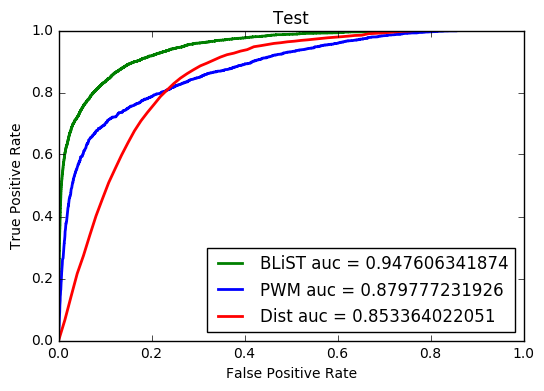

In [20]:
roc(X_train[:, :, :4], y_train, train_preds, 0, 70, 'Train')
roc(X_valid[:, :, :4], y_valid, valid_preds, 0, 70, 'Validation')
roc(X_test[:, :, :4],  y_test,  test_preds,  0, 70, 'Test')

## auPRC on train, valid, test

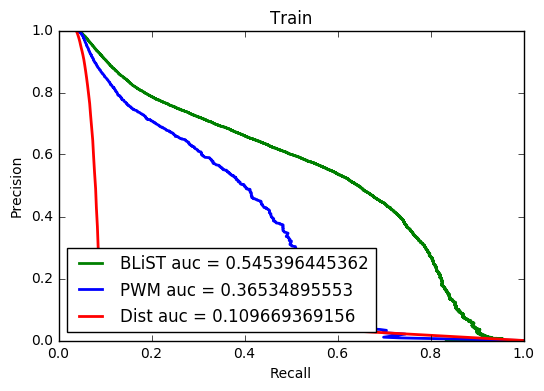

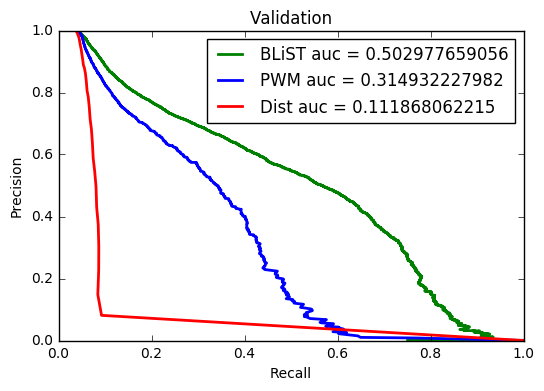

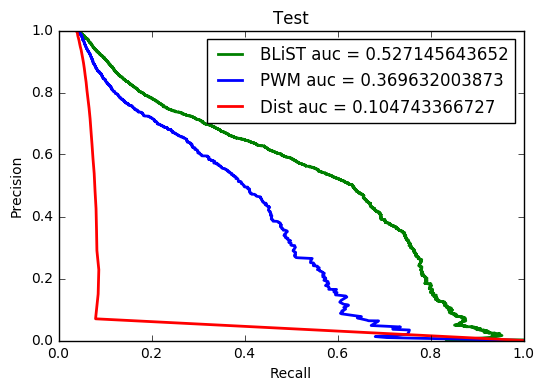

In [21]:
def prc(X, y, p, begin, end, title):
    # Enter begin, end as distance from 3'SS
    # Convert to proper index...
    begin, end = 70 - end, 70 - begin
    
    # Filter for example where BP is in range
    idx = np.sum(y[:, begin:end], axis = 1).flatten() > 0
    _y, _p, _X = y[idx], p[idx], X[idx]
    truth = _y[:, begin:end].flatten()
    
    mask = truth != -1
    
    scores = _p[:, begin:end].flatten()[mask]
    fpr, tpr, thresholds = metrics.precision_recall_curve(truth[mask],
                                                          scores,
                                                          pos_label=1)
    auc = metrics.average_precision_score(truth[mask], scores)
    plt.plot(fpr, tpr, label = "BLiST auc = {}".format(auc), lw = 2, c = 'g')
    
    scores = pwm_pred(_X, pwm)[:, begin:end].flatten()[mask]
    fpr, tpr, thresholds = metrics.precision_recall_curve(truth[mask],
                                                          scores,
                                                          pos_label=1)
    auc = metrics.average_precision_score(truth[mask], scores)
    plt.plot(fpr, tpr, label = "PWM auc = {}".format(auc), lw = 2, c = 'b')
    
    scores = dist_pred(_X, dists)[:, begin:end].flatten()[mask]
    fpr, tpr, thresholds = metrics.precision_recall_curve(truth[mask],
                                                          scores,
                                                          pos_label=1)
    auc = metrics.average_precision_score(truth[mask], scores)
    plt.plot(fpr, tpr, label = "Dist auc = {}".format(auc), lw = 2, c = 'r')
    
    plt.legend(loc = 'best')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title(title)
    plt.show()
    
prc(X_train[:, :, :4], y_train, train_preds, 15, 45, 'Train')
prc(X_valid[:, :, :4], y_valid, valid_preds, 15, 45, 'Validation')
prc(X_test[:, :, :4],  y_test,  test_preds,  15, 45, 'Test')

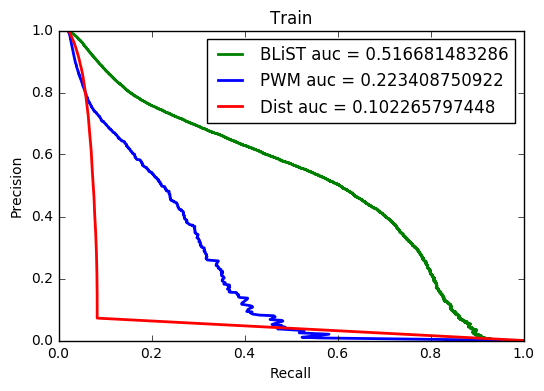

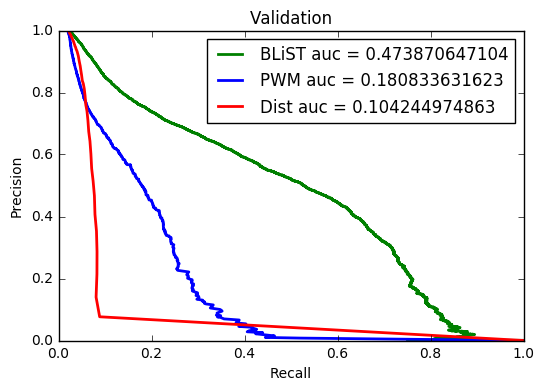

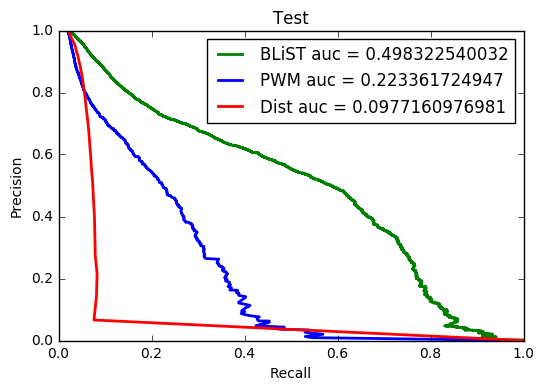

In [22]:
prc(X_train[:, :, :4], y_train, train_preds, 0, 70, 'Train')
prc(X_valid[:, :, :4], y_valid, valid_preds, 0, 70, 'Validation')
prc(X_test[:, :, :4],  y_test,  test_preds,  0, 70, 'Test')

## Matching

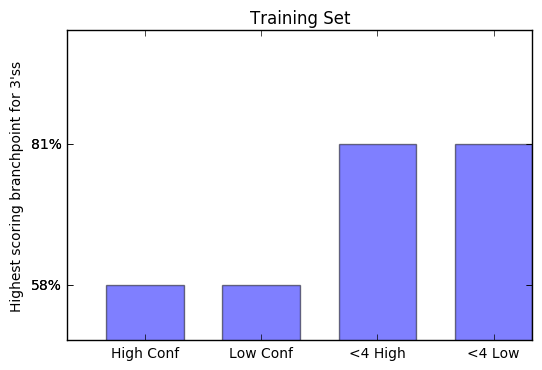

(15110, [0.5892124420913303, 0.5892124420913303, 0.8160820648577102, 0.8160820648577102])


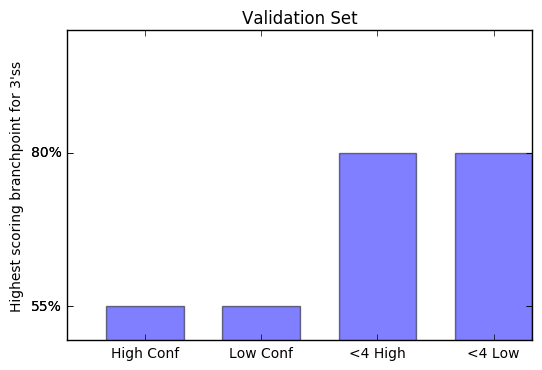

(4568, [0.555385288966725, 0.555385288966725, 0.8025394045534151, 0.8025394045534151])


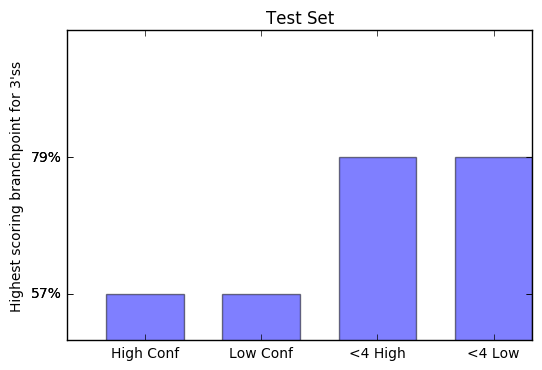

(2342, [0.5755764304013663, 0.5755764304013663, 0.7954739538855679, 0.7954739538855679])


In [23]:
print shifted_matching(train_preds, y_train, 'Training Set')
print shifted_matching(valid_preds, y_valid, 'Validation Set')
print shifted_matching(test_preds,  y_test, 'Test Set') 

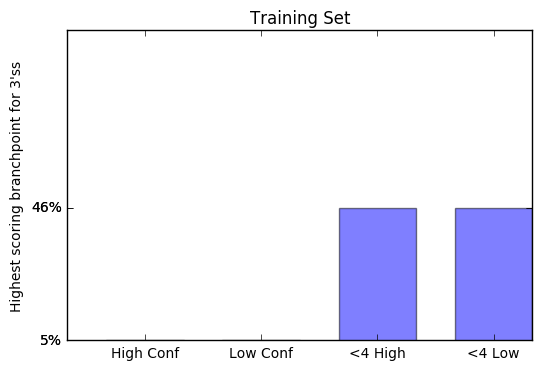

(15110, [0.059497021839841166, 0.059497021839841166, 0.4614824619457313, 0.4614824619457313])


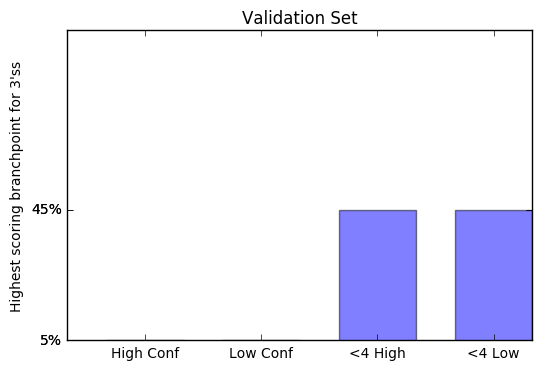

(4568, [0.05691768826619965, 0.05691768826619965, 0.45402802101576184, 0.45402802101576184])


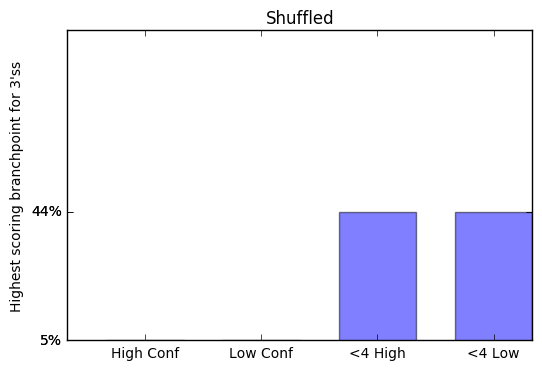

(2342, [0.05081127241673783, 0.05081127241673783, 0.4444918872758326, 0.4444918872758326])


In [24]:
# Shuffled.
from sklearn.utils import shuffle
print shifted_matching(shuffle(train_preds), y_train, 'Training Set')
print shifted_matching(shuffle(valid_preds), y_valid, 'Validation Set')
print shifted_matching(shuffle(test_preds),  y_test, 'Shuffled')

# Count neighboring bases as one

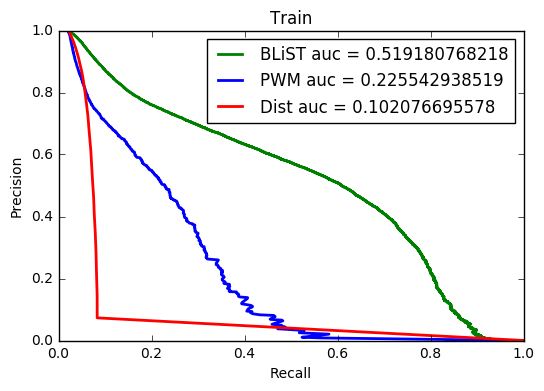

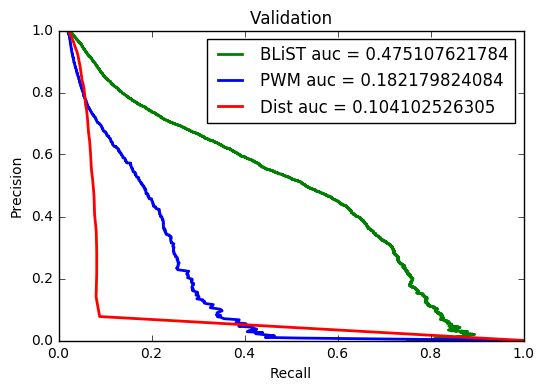

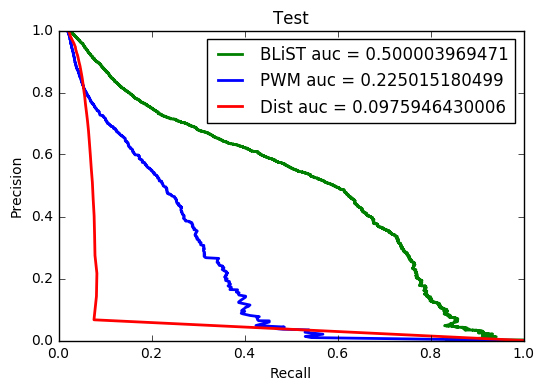

In [25]:
def merge(preds, truth):
    _preds, _truth = [], []
    hot = False
    for p, t in zip(preds, truth):
        if t:
            if hot:
                _preds[-1] = max(_preds[-1], p)
            else:
                _preds += [p]
                _truth += [1]
            hot = True
        else:
            hot = False
            _preds += [p]
            _truth += [0]
    return _truth, _preds

def merged_prc(X, y, p, begin, end, title):
    # Enter begin, end as distance from 3'SS
    # Convert to proper index...
    begin, end = 70 - end, 70 - begin
    
    # Filter for example where BP is in range
    idx = np.sum(y[:, begin:end], axis = 1).flatten() > 0
    _y, _p, _X = y[idx], p[idx], X[idx]
    truth = _y[:, begin:end].flatten()
    
    mask = truth != -1
    
    scores = _p[:, begin:end].flatten()[mask]
    
    t, p = merge(scores, truth[mask])
    fpr, tpr, thresholds = metrics.precision_recall_curve(t, p, pos_label=1)
    auc = metrics.average_precision_score(t, p)
    plt.plot(fpr, tpr, label = "BLiST auc = {}".format(auc), lw = 2, c = 'g')
    
    scores = pwm_pred(_X, pwm)[:, begin:end].flatten()[mask]
    t, p = merge(scores, truth[mask])
    fpr, tpr, thresholds = metrics.precision_recall_curve(t, p, pos_label=1)
    auc = metrics.average_precision_score(t, p)
    plt.plot(fpr, tpr, label = "PWM auc = {}".format(auc), lw = 2, c = 'b')
    
    scores = dist_pred(_X, dists)[:, begin:end].flatten()[mask]
    t, p = merge(scores, truth[mask])
    fpr, tpr, thresholds = metrics.precision_recall_curve(t, p, pos_label=1)
    auc = metrics.average_precision_score(t, p)
    plt.plot(fpr, tpr, label = "Dist auc = {}".format(auc), lw = 2, c = 'r')
    
    plt.legend(loc = 'best')
    plt.ylabel('Precision')
    plt.xlabel('Recall')
    plt.title(title)
    plt.show()

merged_prc(X_train[:, :, :4], y_train, train_preds, 0, 70, 'Train')
merged_prc(X_valid[:, :, :4], y_valid, valid_preds, 0, 70, 'Validation')
merged_prc(X_test[:, :, :4],  y_test,  test_preds,  0, 70, 'Test')

# Remove non-A "branchpoints"

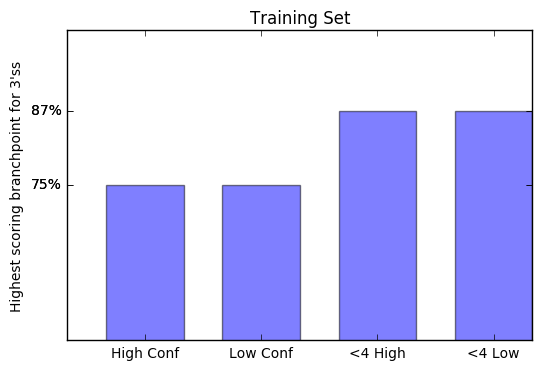

(11558, [0.7515141027859491, 0.7515141027859491, 0.8703928015227548, 0.8703928015227548])


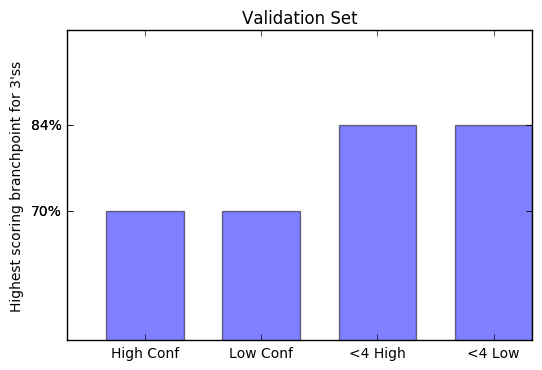

(3497, [0.7086073777523592, 0.7086073777523592, 0.8472976837289105, 0.8472976837289105])


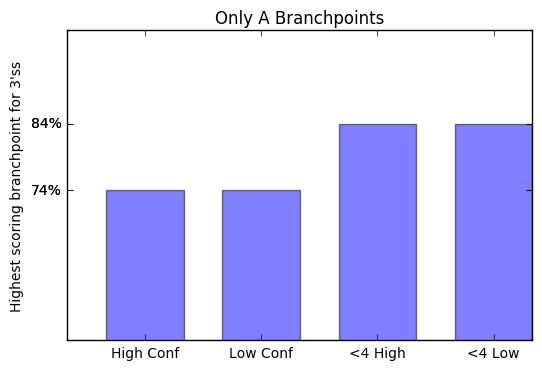

(1772, [0.7420993227990971, 0.7420993227990971, 0.8493227990970654, 0.8493227990970654])


In [26]:
print shifted_matching(train_preds*X_train[:, :, 0],
                       y_train*X_train[:, :, 0], 'Training Set')
print shifted_matching(valid_preds*X_valid[:, :, 0],
                       y_valid*X_valid[:, :, 0], 'Validation Set')
print shifted_matching(test_preds*X_test[:, :, 0],
                       y_test*X_test[:, :, 0], 'Only A Branchpoints') 

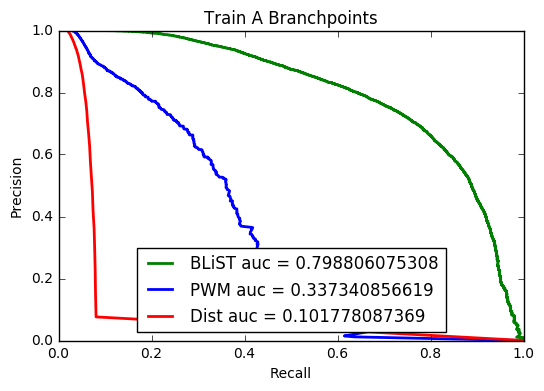

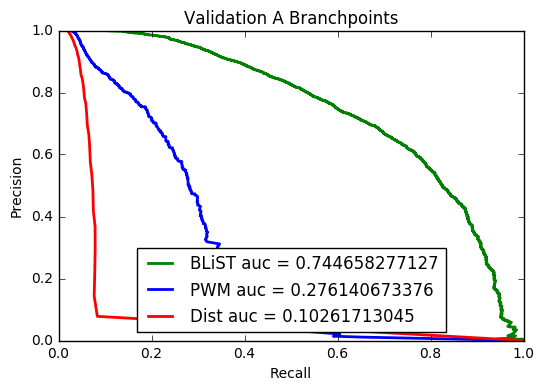

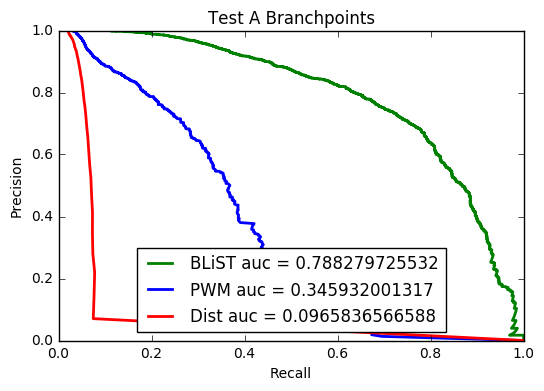

In [27]:
prc(X_train[:, :, :4],
    y_train*X_train[:, :, 0], train_preds*X_train[:, :, 0],
    0, 70, 'Train A Branchpoints')
prc(X_valid[:, :, :4],
    y_valid*X_valid[:, :, 0], valid_preds*X_valid[:, :, 0],
    0, 70, 'Validation A Branchpoints')
prc(X_test[:, :, :4],
    y_test*X_test[:, :, 0], test_preds*X_test[:, :, 0],
    0, 70, 'Test A Branchpoints')